In [19]:
#
import dolfin as df
import numpy as np
import matplotlib.pyplot as plt
import time

from pfbase_ali_mod import *
from ufl import split, dx, inner, grad, variable, diff

save_solution = True

###################################
# Optimization options for the finite element form compiler
###################################
df.parameters["form_compiler"]["cpp_optimize"] = True
df.parameters['form_compiler']['cpp_optimize_flags'] = '-O3 -ffast-math'
df.parameters["form_compiler"]["quadrature_degree"] = 3

###################################
# Create or read mesh
###################################
Lx = Ly = 100.0
Nx = Ny = 100
mesh = df.RectangleMesh(df.Point(0.0, 0.0), df.Point(Lx, Ly), Nx, Ny, 'crossed')

###################################
# Model Setup - need
#   dt, w, w0, F, J, bcs
###################################
dt = df.Constant(1e-1)

# CH parameters
c_alpha = df.Constant(0.3)
c_beta = df.Constant(0.7)
rho = df.Constant(5.0)
kappa = df.Constant(2.0)
M = df.Constant(5.0)
k = df.Constant(0.09)
epsilon = df.Constant(90.0)

# FEM setup
P1 = df.FunctionSpace(mesh, 'P', 1)
PE = P1.ufl_element()
ME = [PE, PE, PE]
ME = df.MixedElement(ME)
W  = df.FunctionSpace(mesh,  ME)

w  = df.Function(W)
dw = df.TrialFunction(W)
w_ = df.TestFunction(W)

# Initial conditions
cc0 = 0.5
cc1 = 0.04

w0 = df.Function(W)
w_ic = InitialConditionsBench6(cc0, cc1, degree=2)
w0.interpolate(w_ic)


# Free Energy
c, _, phi = df.split(w)
c   = df.variable(c)
phi = df.variable(phi)


f_chem = rho * (c - c_alpha)**2 * (c_beta - c)**2
f_elec = k * c * phi / 2.0

dfdc = df.diff(f_chem, c) + k * phi

## weak form
Fc = cahn_hilliard_weak_form(w[0], w[1], w_[0], w_[1], w0[0], dt, M, kappa, dfdc)
Fp = poisson_weak_form(w[2], w_[2], -k * c / epsilon, df.Constant(1.0))

F= Fc + Fp

J = df.derivative(F, w, dw)

bcs = [] # noflux bc

###################################
# Nonlinear solver setup
###################################
df.set_log_level(df.LogLevel.WARNING)

problem = df.NonlinearVariationalProblem(F, w, bcs, J)
solver  = df.NonlinearVariationalSolver(problem)

#solver.parameters['nonlinear_solver'] = 'newton'
#nlparams  = solver.parameters['newton_solver']

solver.parameters['nonlinear_solver'] = 'snes'
nlparams  = solver.parameters['snes_solver']

nlparams['report'] = True
nlparams['error_on_nonconvergence'] = False
nlparams['absolute_tolerance'] = 1e-6
nlparams['maximum_iterations'] = 10

#
#nlparams['line_search'] = 'bt'      # WORKS
#nlparams['line_search'] = 'cp'      # WORKS
nlparams['line_search'] = 'basic'    # WORKS
#nlparams['line_search'] = 'nleqerr' # WORKS
#nlparams['line_search'] = 'l2'      # FAILS

# 
nlparams['linear_solver'] = 'gmres'
nlparams['preconditioner'] = 'sor'

#nlparams['linear_solver'] = 'gmres'
#nlparams['linear_solver'] = 'bicgstab'
#nlparams['linear_solver'] = 'minres'

#nlparams['preconditioner'] = 'none'
#nlparams['preconditioner'] = 'sor'
#nlparams['preconditioner'] = 'petsc_amg'
#nlparams['preconditioner'] = 'hypre_amg'

nlparams['krylov_solver']['maximum_iterations'] = 5000
#nlparams['krylov_solver']['monitor_convergence'] = True

###################################
# analysis setup
###################################
if save_solution:
    filename = "results/bench1_ali/conc"
    outfile = HDF5File(MPI.comm_world, filename + ".h5", "w")
    outfile.write(mesh, "mesh")

def total_solute(c):
    return df.assemble(c * dx)

def total_free_energy(f_chem, kappa, c):
    return df.assemble(f_chem*dx + kappa/2.0*inner(grad(c), grad(c))*dx)

###################################
# time integration
###################################

# Ensure everything is reset
t = df.Constant(0.0)
tprev = 0.0
w.interpolate(w_ic)
w0.interpolate(w_ic)

benchmark_output = []
end_time = df.Constant(1e3) # 1e6
iteration_count = 0
dt_min = 1e-2
dt.assign(1e-1)

t1 = time.time()

while float(t) < float(end_time) + df.DOLFIN_EPS:

    tprev = float(t)

    iteration_count += 1
    if df.MPI.rank(mesh.mpi_comm()) == 0:
        df.warning(f"#================================#")
        df.warning(f"Iteration #{iteration_count}. Time: {float(t)}, dt: {float(dt)}")
        df.warning(f"#================================#")
    else:
        pass

    # set IC
    w0.assign(w)

    # solve
    t.assign(tprev + float(dt))
    niters, converged = solver.solve()

    while not converged:
        #if float(dt) < dt_min + 1E-8:
        #    if df.MPI.rank(mesh.mpi_comm()) == 0:
        #        df.warning(f"dt too small. exiting.")
        #    postprocess()
        #    exit()

        dt.assign(max(0.5*float(dt), dt_min))
        t.assign(tprev + float(dt))
        w.assign(w0)

        if df.MPI.rank(mesh.mpi_comm()) == 0:
            df.warning(f"REPEATING Iteration #{iteration_count}. Time: {float(t)}, dt: {float(dt)}")
        niters, converged = solver.solve()

    # Simple rule for adaptive timestepping
    if (niters < 5):
        dt.assign(2*float(dt))
    else:
        dt.assign(max(0.5*float(dt), dt_min))

    ############
    # Analysis
    ############
    c, _ = w.split()

    if save_solution:
        outfile.write(c , "c" , float(t))

    F_total = total_free_energy(f_chem, kappa, c)
    C_total = total_solute(c)
    benchmark_output.append([float(t), F_total, C_total])

    if df.MPI.rank(mesh.mpi_comm()) == 0:
        df.warning(f"C_total: {C_total}, TFE: {F_total}")

t2 = time.time()
spent_time = t2 - t1
if df.MPI.rank(mesh.mpi_comm()) == 0:
    warning(f"Time spent is {spent_time}")
else:
    pass

###################################
# post process
###################################
if df.MPI.rank(mesh.mpi_comm()) == 0:
    np.savetxt('results/bench1_ali/' + 'stats.csv',
            np.array(benchmark_output),
            fmt='%1.10f',
            header="time,total_free_energy,total_solute",
            delimiter=',',
            comments=''
            )
else:
    pass


Calling FFC just-in-time (JIT) compiler, this may take some time.


/home/andrew/anaconda3/envs/PF-env/lib/python3.11/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/andrew/anaconda3/envs/PF-env/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


Calling FFC just-in-time (JIT) compiler, this may take some time.


HDF5-DIAG: Error detected in HDF5 (1.12.2) MPI-process 0:
  #000: H5F.c line 532 in H5Fcreate(): unable to create file
    major: File accessibility
    minor: Unable to open file
  #001: H5VLcallback.c line 3282 in H5VL_file_create(): file create failed
    major: Virtual Object Layer
    minor: Unable to create file
  #002: H5VLcallback.c line 3248 in H5VL__file_create(): file create failed
    major: Virtual Object Layer
    minor: Unable to create file
  #003: H5VLnative_file.c line 63 in H5VL__native_file_create(): unable to create file
    major: File accessibility
    minor: Unable to open file
  #004: H5Fint.c line 1858 in H5F_open(): unable to truncate a file which is already open
    major: File accessibility
    minor: Unable to open file
HDF5-DIAG: Error detected in HDF5 (1.12.2) MPI-process 0:
  #000: H5L.c line 938 in H5Lexists(): invalid location identifier
    major: Invalid arguments to routine
    minor: Inappropriate type
HDF5-DIAG: Error detected in HDF5 (1.12.2) MP

*** Warning: #================================#
*** Warning: Iteration #1. Time: 0.0, dt: 0.1
*** Warning: #================================#
  0 SNES Function norm 1.646397546963e+00 
  *** Warning: PETSc SNES solver diverged in 0 iterations with divergence reason DIVERGED_LINEAR_SOLVE.
*** Warning: REPEATING Iteration #1. Time: 0.05, dt: 0.05
  0 SNES Function norm 1.646397546963e+00 
  *** Warning: PETSc SNES solver diverged in 0 iterations with divergence reason DIVERGED_LINEAR_SOLVE.


KeyboardInterrupt: 

In [35]:
#
import dolfin as df
import numpy as np
import matplotlib.pyplot as plt
import time

from pfbase import *
from ufl import split, dx, inner, grad, variable, diff

save_solution = True

###################################
# Optimization options for the finite element form compiler
###################################
df.parameters["form_compiler"]["cpp_optimize"] = True
df.parameters['form_compiler']['cpp_optimize_flags'] = '-O3 -ffast-math'
df.parameters["form_compiler"]["quadrature_degree"] = 3

###################################
# Create or read mesh
###################################
Lx = Ly = 100.0
Nx = Ny = 50
mesh = df.RectangleMesh(df.Point(0.0, 0.0), df.Point(Lx, Ly), Nx, Ny, 'crossed')

###################################
# Model Setup - need
#   dt, w, w0, F, J, bcs
###################################
dt = df.Constant(1e-1)

# parameters
c_alpha = df.Constant(0.3)
c_beta = df.Constant(0.7)
kappa = df.Constant(2.0)
rho = df.Constant(5.0)
M = df.Constant(5.0)
k = df.Constant(0.09)
epsilon = df.Constant(90.0)

# FEM setup
P1 = df.FunctionSpace(mesh, 'P', 1)
PE = P1.ufl_element()
ME = [PE, PE, PE, PE, PE]
ME = df.MixedElement(ME)
W  = df.FunctionSpace(mesh,  ME)

w  = df.Function(W)
dw = df.TrialFunction(W)
w_ = df.TestFunction(W)

# Initial conditions
cc0 = 0.5
cc1 = 0.04

w0 = df.Function(W)
w_ic = InitialConditionsBench6(cc0, cc1, degree=2)
w0.interpolate(w_ic)

# Free energy functional
c, _, phi, ux, uy = df.split(w)
c   = df.variable(c)
phi = df.variable(phi)

f_chem = rho * (c - c_alpha)**2 * (c_beta - c)**2
f_elec = k * c * phi / 2.0
f_m = 0

dfdc = df.diff(f_chem, c) + k * phi + 0










## weak form
Fc = cahn_hilliard_weak_form(w[0], w[1], w_[0], w_[1], w0[0], dt, M, kappa, dfdc)
Fp = poisson_weak_form(w[2], w_[2], -k * c / epsilon, df.Constant(1.0))
Fm = mech_weak_form(w[3], w[4], 1, 1)

F= Fc + Fp+Fm

# BC
tol = 1E-12
def boundary_left(x, on_boundary):
    return on_boundary and df.near(x[0], 0, tol)

def boundary_right(x, on_boundary):
    return on_boundary and df.near(x[0], Lx, tol)

phi_right = df.Expression(("sin(x[1]/7)"), degree=2)

_, _, Wphi, ux_bc, uy_bc= W.split()
bc_left  = df.DirichletBC(Wphi, df.Constant(0.0), boundary_left)
bc_right = df.DirichletBC(Wphi, phi_right, boundary_right)

bcs = [bc_left, bc_right] # no-flux on top, bottom boundary

###############
J = df.derivative(F, w, dw)

###################################
# Nonlinear solver setup
###################################
df.set_log_level(df.LogLevel.ERROR)

problem = df.NonlinearVariationalProblem(F, w, bcs, J)
solver  = df.NonlinearVariationalSolver(problem)

#solver.parameters['nonlinear_solver'] = 'newton'
#nlparams  = solver.parameters['newton_solver']

solver.parameters['nonlinear_solver'] = 'snes'
nlparams  = solver.parameters['snes_solver']

nlparams['report'] = True
nlparams['error_on_nonconvergence'] = False
nlparams['absolute_tolerance'] = 1e-6
nlparams['maximum_iterations'] = 10

#
# bactracig (bt) diverges with only Laplace eqn
#nlparams['line_search'] = 'bt'      # WORKS (7s) for np=32, T=3.0
nlparams['line_search'] = 'cp'       # (8s) #
#nlparams['line_search'] = 'basic'   # (7s)
#nlparams['line_search'] = 'nleqerr' # (15s)
#nlparams['line_search'] = 'l2'      # FAILING

# 
nlparams['linear_solver'] = 'gmres'
nlparams['preconditioner'] = 'sor'

#nlparams['linear_solver'] = 'gmres'
#nlparams['linear_solver'] = 'bicgstab'
#nlparams['linear_solver'] = 'minres'

#nlparams['preconditioner'] = 'none'
#nlparams['preconditioner'] = 'sor'
#nlparams['preconditioner'] = 'petsc_amg'
#nlparams['preconditioner'] = 'hypre_amg'

nlparams['krylov_solver']['maximum_iterations'] = 5000
#nlparams['krylov_solver']['monitor_convergence'] = True

###################################
# analysis setup
###################################
if save_solution:
    dirname = "results/bench6/"
    filename0 = dirname + "conc"
    filename1 = dirname + "phi"
    #cfile = df.XDMFFile(filename + ".xdmf")
    #for f in [cfile, ]:
    #    f.parameters['flush_output'] = True
    #    f.parameters['rewrite_function_mesh'] = False

    #cfile.write(w.sub(0), 0.0)

    file0 = df.File(filename0 + ".pvd")
    file1 = df.File(filename1 + ".pvd")

def total_solute(c):
    return df.assemble(c * dx)

def total_free_energy(f_chem, f_elec, kappa):
    E = df.assemble((
        f_chem +
        f_elec +
        kappa / 2.0 * inner(grad(c), grad(c))
        )*dx)

    return E

###################################
# time integration
###################################

# Ensure everything is reset
t = df.Constant(0.0)
tprev = 0.0
w.interpolate(w_ic)
w0.interpolate(w_ic)

benchmark_output = []
end_time = df.Constant(3) # 400.0
iteration_count = 0
dt_min = 1e-4
dt.assign(1e-2)
t1 = time.time()

while float(t) < float(end_time) + df.DOLFIN_EPS:

    tprev = float(t)

    iteration_count += 1
    if df.MPI.rank(mesh.mpi_comm()) == 0:
        print(f'Iteration #{iteration_count}. Time: {float(t)}, dt: {float(dt)}')
    else:
        pass

    # set IC
    w0.assign(w)

    # solve
    t.assign(tprev + float(dt))
    niters, converged = solver.solve()

    while not converged:
        #if float(dt) < dt_min + 1E-8:
        #    if df.MPI.rank(mesh.mpi_comm()) == 0:
        #        print("dt too small. exiting.")
        #    postprocess()
        #    exit()

        dt.assign(max(0.5*float(dt), dt_min))
        t.assign(tprev + float(dt))
        w.assign(w0)

        if df.MPI.rank(mesh.mpi_comm()) == 0:
            print(f'REPEATING Iteration #{iteration_count}. Time: {float(t)}, dt: {float(dt)}')
        niters, converged = solver.solve()

    # Simple rule for adaptive timestepping
    if (niters < 5):
        dt.assign(2*float(dt))
    else:
        dt.assign(max(0.5*float(dt), dt_min))

    ############
    # Analysis
    ############
    c, _, phi = w.split()

    if save_solution:
        file0 << (c, t)
        file1 << (phi, t)
        #cfile.write(c, float(t))

    F_total = total_free_energy(f_chem, f_elec, kappa)
    C_total = total_solute(c)
    benchmark_output.append([float(t), F_total, C_total])

t2 = time.time()
spent_time = t2 - t1
if df.MPI.rank(mesh.mpi_comm()) == 0:
    print(f'Time spent is {spent_time}')
else:
    pass

###################################
# post process
###################################
if df.MPI.rank(mesh.mpi_comm()) == 0:
    np.savetxt('results/bench6' + '_out.csv',
            np.array(benchmark_output),
            fmt='%1.10f',
            header="time,total_free_energy,total_solute",
            delimiter=',',
            comments=''
            )
else:
    pass


RuntimeError: 

*** -------------------------------------------------------------------------
*** DOLFIN encountered an error. If you are not able to resolve this issue
*** using the information listed below, you can ask for help at
***
***     fenics-support@googlegroups.com
***
*** Remember to include the error message listed below and, if possible,
*** include a *minimal* running example to reproduce the error.
***
*** -------------------------------------------------------------------------
*** Error:   Unable to interpolate function into function space.
*** Reason:  Dimension 0 of function (3) does not match dimension 0 of function space (5).
*** Where:   This error was encountered inside FunctionSpace.cpp.
*** Process: 0
*** 
*** DOLFIN version: 2019.1.0
*** Git changeset:  3ea2183fbfe7277de9f16cbe1a9ffaab133ba1fa
*** -------------------------------------------------------------------------


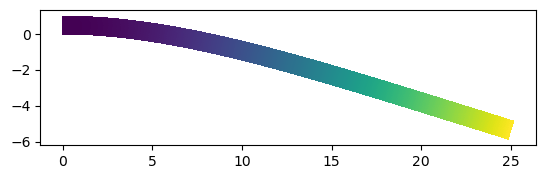

In [32]:
L = 25.

H = 1.
Nx = 250
Ny = 10
mesh = RectangleMesh(Point(0., 0.), Point(L, H), Nx, Ny, "crossed")

def eps(v):
    return sym(grad(v))

E = Constant(1e5)
nu = Constant(0.3)
model = "plane_stress"

mu = E/2/(1+nu)
lmbda = E*nu/(1+nu)/(1-2*nu)
if model == "plane_stress":
    lmbda = 2*mu*lmbda/(lmbda+2*mu)

def sigma(v):
    return lmbda*tr(eps(v))*Identity(2) + 2.0*mu*eps(v)

rho_g = 1e-3
f = Constant((0, -rho_g))

V = VectorFunctionSpace(mesh, 'Lagrange', degree=2)
du = TrialFunction(V)
u_ = TestFunction(V)
a = inner(sigma(du), eps(u_))*dx
l = inner(f, u_)*dx

def left(x, on_boundary):
    return near(x[0], 0.)

bc = DirichletBC(V, Constant((0.,0.)), left)

u = Function(V, name="Displacement")
solve(a == l, u, bc)

plot(1e3*u, mode="displacement")